In [15]:
import os
import pathlib
import sys
from pathlib import __file__

import numpy as np
import tensorflow as tf

sys.path.insert(0, pathlib.Path().absolute().parent.parent.parent.__str__())
sys.path.append(os.path.join(os.path.dirname(__file__), "../../../../src"))

sys.dont_write_bytecode = True

from LSC_recognizer_model.src.dinamic.data.split_dataset import SplitDataset
from LSC_recognizer_model.src.dinamic.utils.video_utils import get_only_specific_parts_and_fix_video


# IMPORTANTE:
### Los videos deben ser de de 5 segundos o menos

In [16]:
# ----------------- PATHS --------------------------

PATH_PREDICTED_IMG = "../../data/processed/DrawDinamic"

PATH_RAW_SIGNS = "../../data/raw/SignsDinamic"
PATH_RAW_NUMPY = "../../data/processed/NumpyDinamic"

PATH_CHECKPOINTS_LOAD = "../../models/checkpoints-dinamic-prueba"
PATH_CHECKPOINTS_SAVE = "../../models/checkpoints-dinamic-prueba"

# 1. Capa Split Dataset (Train, Validation y Test)

In [17]:
# Comentar esta celda una vez se haya ejecutado por primera vez
#split_dataset = SplitDataset(path_raw_image=PATH_RAW_SIGNS)
#train, test, validation, _ = split_dataset.get_splited_files(save_path_numpy=PATH_RAW_NUMPY)
# 5 min 200 videos

In [18]:
split_dataset = SplitDataset(
    path_raw_numpy=PATH_RAW_NUMPY,
    porcentage_train=1,
    porcentage_test=0,
    porcentage_validation=0
)
train, test, validation, _ = split_dataset.get_splited_files()

# 2. Arreglo datos
Este proceso es para ajustar correctamente los datos para usar solo las coordenadas de los landmarks que se van a usar.

In [19]:
FPS = 20
SECONDS = 3

X_train, Y_train = get_only_specific_parts_and_fix_video(
    train,
    used_parts=["pose", "left_hand", "right_hand"],
    max_total_fps_video=FPS * SECONDS,
)
X_test, Y_test = get_only_specific_parts_and_fix_video(
    test,
    used_parts=["pose", "left_hand", "right_hand"],
    max_total_fps_video=FPS * SECONDS,
)
X_validation, Y_validation = get_only_specific_parts_and_fix_video(
    validation,
    used_parts=["pose", "left_hand", "right_hand"],
    max_total_fps_video=FPS * SECONDS,
)

In [20]:
len(X_train), len(Y_train)

(200, 200)

In [21]:
len(X_validation), len(Y_validation)

(0, 0)

In [22]:
X_train.shape

(200, 60, 226)

In [23]:
Y_train.shape

(200, 6)

# 4. Capa Modelo

In [24]:
classes = split_dataset.get_classes()
steps_per_epoch = split_dataset.get_recomend_steps_per_epoch()

## 4.1 Creación de capa modelo
Se ingresa el modelo creado y los datos de entrenamiento y validación.

In [25]:
INPUT_SHAPE = (FPS * SECONDS, 226)

def get_model_dinamic_coord(input_shape, num_classes):
    return tf.keras.Sequential(
        [
            tf.keras.layers.LSTM(64, return_sequences=True, activation="relu", input_shape=input_shape),
            tf.keras.layers.LSTM(128, return_sequences=True, activation="relu"),
            tf.keras.layers.LSTM(64, return_sequences=False, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

def get_model_dinamic_coord(input_shape, num_classes):
    return tf.keras.Sequential(
        [
            tf.keras.layers.LSTM(64, return_sequences=True, activation="relu", input_shape=input_shape),
            tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
            tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

In [26]:
from LSC_recognizer_model.src.utils.sign_model import SignModel

modelo = SignModel(
    model = get_model_dinamic_coord(INPUT_SHAPE, len(classes)),
    dataset_train = None,
    dataset_validation = None,
    X_train = X_train,
    Y_train = Y_train,
    #X_validation = X_validation,
    #Y_validation = Y_validation
)

## 4.2 Definir callbacks

In [27]:
from keras.callbacks import ModelCheckpoint, TensorBoard

# ============ TensorBoard ============
# To open tensorboard: tensorboard --logdir=. on the folder where the logs are.
log_dir = f"{PATH_CHECKPOINTS_SAVE}/logs"
tb_callback = TensorBoard(log_dir=log_dir)

# ============ Checkpoints ============
checkpoint_filepath = PATH_CHECKPOINTS_SAVE
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# ========== Callbacks list ============
callbacks_list = [checkpoint, tb_callback]

# 4.3 Entrenar modelo

In [28]:
modelo.train_model(
    epochs = 1000,
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy"],
    callbacks = callbacks_list,
    steps_per_epoch = steps_per_epoch,
    verbose=1,
)

Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 1.8616 - categorical_accuracy: 0.1950
Epoch 1: categorical_accuracy improved from -inf to 0.19500, saving model to ../../models\checkpoints-dinamic-prueba
INFO:tensorflow:Assets written to: ../../models\checkpoints-dinamic-prueba\assets
7/7 [==============================] - 5s 552ms/step - loss: 1.8616 - categorical_accuracy: 0.1950
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.8160 - categorical_accuracy: 0.2150
Epoch 2: categorical_accuracy improved from 0.19500 to 0.21500, saving model to ../../models\checkpoints-dinamic-prueba
INFO:tensorflow:Assets written to: ../../models\checkpoints-dinamic-prueba\assets
7/7 [==============================] - 3s 521ms/step - loss: 1.8160 - categorical_accuracy: 0.2150
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.7276 - categorical_accuracy: 0.2550
Epoch 3: categorical_accuracy improved from 0.21500 to 0.25500, saving model to ../

## 4.4 Guardar results del entrenamiento

KeyError: 'val_loss'

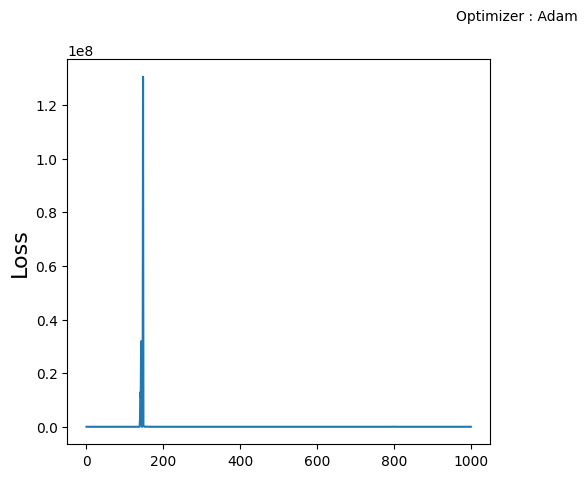

In [29]:
plot_acc_los, plot_confusion_matrix = modelo.save_plot_results(
    X_test = X_test,
    Y_test = Y_test,
    path_to_save = PATH_CHECKPOINTS_SAVE
)

# 5. Cargar Pesos de modelo
Esto se puede usar cuando se quiere cargar los pesos de un modelo ya entrenado sin tener que volver a entrenar el modelo.

In [40]:
modelo.load_model_weights(PATH_CHECKPOINTS_SAVE)

In [43]:
import time

import cv2
from utils.holistic.holistic_detector import HolisticDetector

ptiempo = 0

sequence = []
predictions = []

# Crearemos el objeto
holistic = HolisticDetector()

# Leemos la cámara web
cap = cv2.VideoCapture(0)

count_prediction_x_frames = 10
count = 0

while cap.isOpened():
    
    # Leemos el fotograma de la cámara
    success, image = cap.read()

    if not success:
        break

    # Una vez que obtengamos la imagen la enviaremos
    results = holistic.detect_holistic(image)
    
    # Dibujamos la predicción en el fotograma
    #image = holistic.draw_prediction(image, results)

    # Predicción
    x = holistic.get_coordenates(results, used_parts=["pose", "right_hand", "left_hand"])
    sequence.append(x)
    sequence = sequence[-FPS * SECONDS:]

    count += 1

    if len(sequence) == FPS * SECONDS:
        try:
            if count % count_prediction_x_frames == 0:
                res = modelo.get_prediction(sequence, classes)
                predictions.append(res)
                print(res[0])
                print()
        except Exception as e:
            print("Error: ", e)

    # Viz probabilities
    #image = holistic.probability_visualizer(res, classes, image)

    # Mostramos los fps
    ctiempo = time.time()
    fps = 1 / (ctiempo - ptiempo)
    ptiempo = ctiempo
    cv2.putText(image, str(int(fps)), (image.shape[1]-100, 70), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 3)

    # Mostramos todo el fotograma modificado
    cv2.imshow("holistic", image)

    # Break gracefully
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

    
cap.release()
cv2.destroyAllWindows()

('abril', 36)

('abril', 24)

('abril', 24)

('abril', 26)

('abril', 26)

('a veces', 31)

('a veces', 41)

('a veces', 36)

('aceptar', 44)

('aceptar', 86)

('abrigo', 60)

('abrazar', 99)

('abrazar', 99)

('abrazar', 94)

('a veces', 63)

('abril', 64)

('abril', 41)

('a veces', 48)

('a veces', 46)

('a veces', 43)

('abril', 66)

('aceptar', 98)

('aceptar', 99)

('abrazar', 70)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 99)

('abrazar', 97)

('abandonar', 49)

('a veces', 90)

('a veces', 66)

('a veces', 60)

('a veces', 58)

('a veces', 62)

('abril', 75)

('abril', 58)

('abril', 50)

('a veces', 69)

('a veces', 56)

('abril', 52)

('a veces', 58)

('abril', 57)

('abril', 58)

('abril', 89)

('abril', 82)

('a veces', 58)

('a veces', 62)

('a veces', 82)

('a veces', 76)

('a veces', 70)

('abril', 58)

('a veces', 71)

('a veces', 60)

('a veces', 7

In [38]:
sequence[5]

array([0.46414125, 0.04353099, 0.0535903 , 0.99961084, 0.5071133 ,
       0.        , 0.1208809 , 0.999158  , 0.5313263 , 0.00235036,
       0.12077286, 0.9993609 , 0.5547426 , 0.00599062, 0.11996225,
       0.9992847 , 0.42289376, 0.00148957, 0.10845529, 0.9992787 ,
       0.3946803 , 0.00439455, 0.10831157, 0.9994306 , 0.36706454,
       0.00862943, 0.10773533, 0.99934876, 0.59915215, 0.04036366,
       0.51261234, 0.99922675, 0.3376291 , 0.04774979, 0.4789649 ,
       0.9993355 , 0.518594  , 0.09955179, 0.20032583, 0.9995432 ,
       0.40872252, 0.10249157, 0.18909834, 0.99960154, 0.7967189 ,
       0.30981857, 0.71436137, 0.9995465 , 0.17850566, 0.32778114,
       0.657716  , 0.99946105, 0.9724335 , 0.6679963 , 0.7503521 ,
       0.8758012 , 0.        , 0.6828722 , 0.6136244 , 0.86196196,
       0.95069665, 0.90339833, 0.4524325 , 0.58114433, 0.09843593,
       0.87712634, 0.18081625, 0.6552866 , 1.        , 0.98386705,
       0.36885738, 0.5295384 , 0.07642479, 0.94655275, 0.06727